<a href="https://colab.research.google.com/github/Epalaciol/VisionArtificial_2021_Retinas/blob/master/TrabajoRetinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Vision Artificial Retinas

##Integrantes: 
- Alejandra Betancur Palacio
- Juan Camilo  Molina Roncancio
- Esteban Palacio Londoño
- Valentina Tamayo Guarin 
- Mateo Valencia Diaz
- Angie Tatiana Solano Rodriguez


## Introducción

[Inserte aqui la intro]


## Preprocesamiento de imagenes

In [39]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import io, color

In [41]:
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None
    

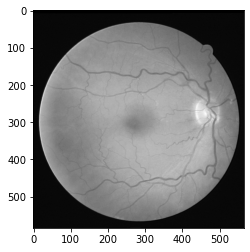

In [4]:
imagenUno = cv2.imread("images/training/images/22_training.tif", cv2.IMREAD_GRAYSCALE)
plt.imshow(imagenUno, cmap= "gray")

#Segmentación 

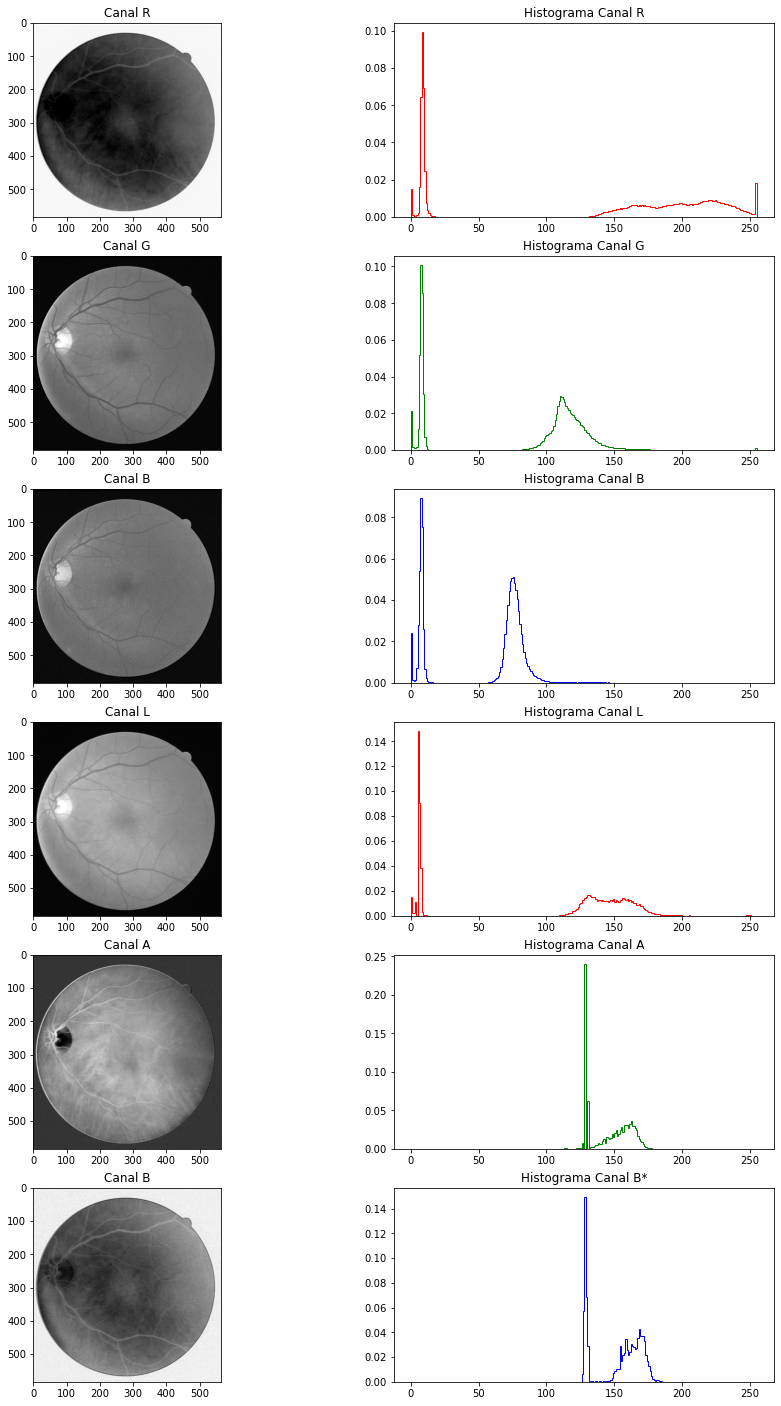

In [42]:
img_R1 = img_rgb[:,:,0]
img_R =cv2.bitwise_not(img_R1)
img_G = img_rgb[:,:,1]

#img_G =cv2.bitwise_not(img_G1)
img_B = img_rgb[:,:,2]
#img_B =cv2.bitwise_not(img_B1)
img_lab= cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB) 
img_L = img_lab[:,:,0]
img_A =  img_lab[:,:,1]
img_BB1 = img_lab[:,:,2]
img_BB =cv2.bitwise_not(img_BB1)
fig, arreglo_plots = plt.subplots(6,2, figsize=(15, 25))
colors = ('r','g','b')

#Espacio de color RGB
arreglo_plots[0,0].set_title('Canal R')
arreglo_plots[0,0].imshow(img_R, cmap="gray")
arreglo_plots[0,1].set_title('Histograma Canal R')
img_array_i = img_rgb[:,:,0].ravel()
arreglo_plots[0,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[0])

arreglo_plots[1,0].set_title('Canal G')
arreglo_plots[1,0].imshow(img_G, cmap="gray")
arreglo_plots[1,1].set_title('Histograma Canal G')
img_array_i = img_rgb[:,:,1].ravel()
arreglo_plots[1,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[1])
    
arreglo_plots[2,0].set_title('Canal B')
arreglo_plots[2,0].imshow(img_B, cmap="gray")
arreglo_plots[2,1].set_title('Histograma Canal B')
img_array_i = img_rgb[:,:,2].ravel()
arreglo_plots[2,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[2])

#Espacio de color LAB
arreglo_plots[3,0].set_title('Canal L')
arreglo_plots[3,0].imshow(img_L, cmap="gray")
arreglo_plots[3,1].set_title('Histograma Canal L')
img_array_i = img_lab[:,:,0].ravel()
arreglo_plots[3,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[0])

arreglo_plots[4,0].set_title('Canal A')
arreglo_plots[4,0].imshow(img_A, cmap="gray")
arreglo_plots[4,1].set_title('Histograma Canal A')
img_array_i = img_lab[:,:,1].ravel()
arreglo_plots[4,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[1])
    
arreglo_plots[5,0].set_title('Canal B')
arreglo_plots[5,0].imshow(img_BB, cmap="gray")
arreglo_plots[5,1].set_title('Histograma Canal B*')
img_array_i = img_lab[:,:,2].ravel()
arreglo_plots[5,1].hist(img_array_i,histtype='step', bins=255, 
                            range=(0.0, 255.0),density=True, color=colors[2]);


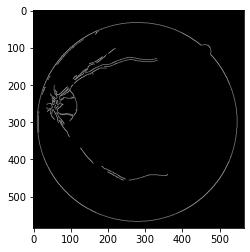

In [43]:
img_G = img_rgb[:,:,1]
edges = cv2.Canny(img_G,90,180)
plt.imshow(edges, cmap = "gray")